# Twice trainig + Mixup 
参照ノートブック: [EfficientNetB0 Starter](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43)  

**変更点**
1. データの投票数による重要度の解釈をもとに、訓練を繰り返す（1回目：全データ、2回目：重要度の高いと思われるデータ）  
※重要度の判定は、各データの投票率の分布と等確率の（1/6）の時の分布の間のkl_divで判定する。kl_divの閾値は5.5で、それ以下のデータ、つまりより等確率に近いデータ（脳波種判定が難しいデータ）を重点的に学習するようにした。  
2. Mixup,Cutoutによるデータ拡張  
※ほかのデータ拡張法も試行しましたが、結果が向上したのはこの組み合わせだけでした。  

その他の試行したデータ拡張  
HorizontalFlip, VerticalFlip, Random Brightness/Contrast, GaussianBlur

二つの変更点により、参照ノートブックの最良スコア（CV_score:0.59, LB_score:0.43）から両スコアが改善した。  
**score(訓練データ別)**
- Kaggle's spectrograms (CV 0.61 - LB 0.41)
- Chris's EEG spectrograms(modified version) (CV 0.62 - LB 0.39)
- Both Kaggle and EEG spectrograms (CV 0.56 - LB 0.38)

**モデルのleakageについて**  
対処として、1回目と2回目のクロスバリデーションによる分割を同時に行い、1回目の検証データを2回目で学習しないように施した。

In [1]:
import os, random
import tensorflow as tf
import tensorflow
import tensorflow.keras.backend as K
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import keras_cv

LOAD_BACKBONE_FROM = '/kaggle/input/efficientnetb-tf-keras/EfficientNetB2.h5'
LOAD_MODELS_FROM = '/kaggle/input/features-head-starter-models/'
VER = 1
DATA_TYPE = 'both' # both|eeg|kaggle|raw   # 両方のspecでMixUpしたい
TEST_MODE = False
submission = False # 訓練

# 再現性の確保
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

gpus = tf.config.list_physical_devices('GPU')
# 混合精度を設定
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
if len(gpus)>1:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')

Using TensorFlow backend
Using 0 GPU


# eeg_idごとにデータを統括  
testデータにあわせてeeg_idごとに単一のデータを持つような訓練データを作成。  


In [2]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS2,range(len(FEATS2)))}

# def eeg_from_parquet(parquet_path):

#     eeg = pd.read_parquet(parquet_path, columns=FEATS2)
#     rows = len(eeg)
#     offset = (rows-10_000)//2
#     eeg = eeg.iloc[offset:offset+10_000]
#     data = np.zeros((10_000,len(FEATS2)))
#     for j,col in enumerate(FEATS2):
        
#         # FILL NAN
#         x = eeg[col].values.astype('float32')
#         m = np.nanmean(x)
#         if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
#         else: x[:] = 0
        
#         data[:,j] = x

#     return data

# 訓練データを抽出する指標
def add_kl(data):
    import torch
    labels = data[TARGETS].values + 1e-5

    # compute kl-loss with uniform distribution by pytorch
    data['kl'] = torch.nn.functional.kl_div(
        torch.log(torch.tensor(labels)),
        torch.tensor([1 / 6] * 6),
        reduction='none'
    ).sum(dim=1).numpy()
    return data

if not submission:
    train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
    TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    META = ['spectrogram_id','spectrogram_label_offset_seconds','patient_id','expert_consensus']
    train = train.groupby('eeg_id')[META+TARGETS
                           ].agg({**{m:'first' for m in META},**{t:'sum' for t in TARGETS}}).reset_index() 
    train[TARGETS] = train[TARGETS]/train[TARGETS].values.sum(axis=1,keepdims=True)
    train.columns = ['eeg_id','spec_id','offset','patient_id','target'] + TARGETS
    train = add_kl(train)
    print(train.head(1).to_string())

   eeg_id    spec_id  offset  patient_id target  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote        kl
0  568657  789577333     0.0       20654  Other           0.0       0.0      0.25        0.0   0.166667    0.583333  4.584192


# データのkl_divの分布を可視化 

<Axes: ylabel='Frequency'>

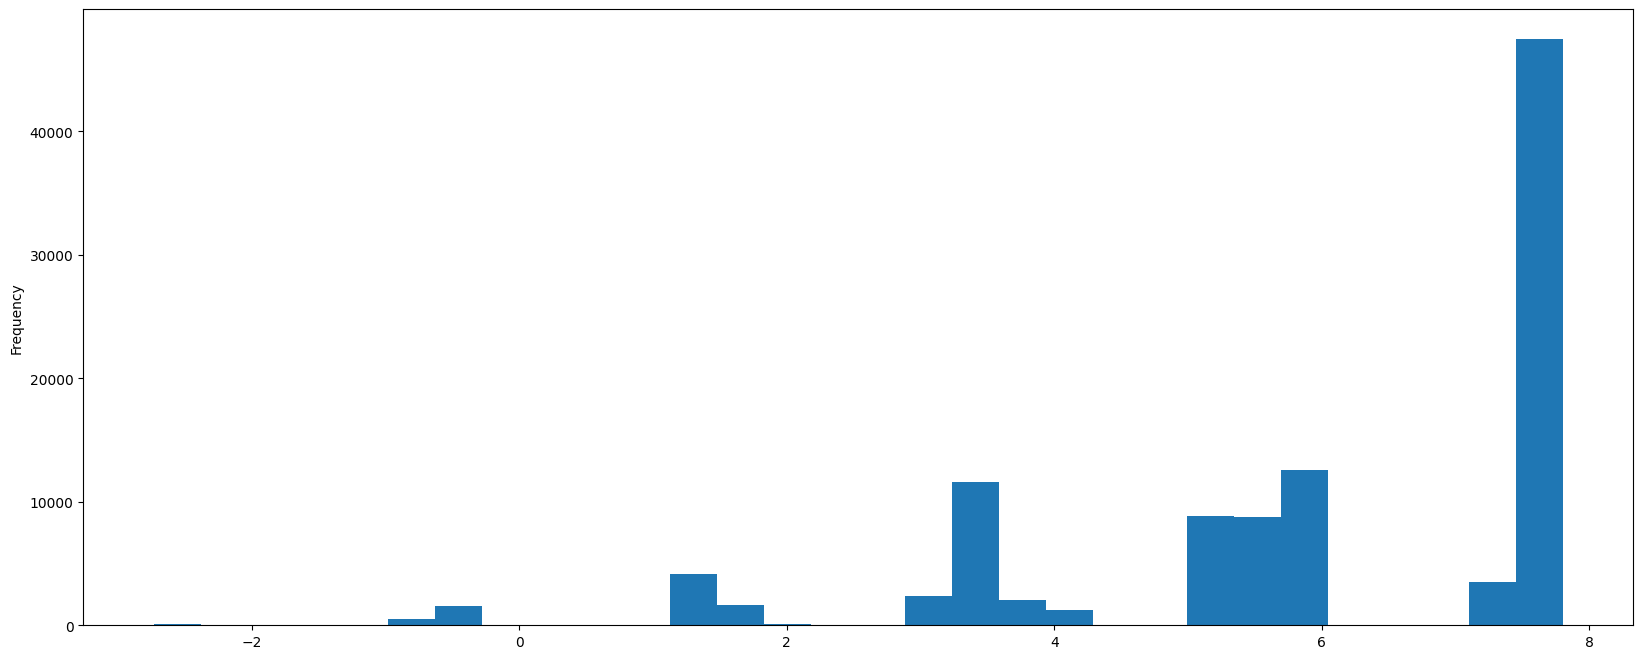

In [3]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
df['total_vote'] = df[TARGETS].sum(axis=1)
df = add_kl(df)
plt.figure(figsize=(20,8))
df['kl'].plot(kind='hist', bins=30)

# spectrograms,eegsの読み込み

In [4]:
%%time
if not submission:
    # FOR TESTING SET READ_FILES TO TRUE
    if TEST_MODE:
        train = train.sample(500,random_state=42).reset_index(drop=True)
        spectrograms = {}
        for i,e in enumerate(train.spec_id.values):
            if i%100==0: print(i,', ',end='')
            x = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/{e}.parquet')
            spectrograms[e] = x.values
        all_eegs = {}
        for i,e in enumerate(train.eeg_id.values):
            if i%100==0: print(i,', ',end='')
            x = np.load(f'/kaggle/input/eeg-spectrograms/EEG_Spectrograms/{e}.npy')
            all_eegs[e] = x
        all_raw_eegs = {}
        for i,e in enumerate(train.eeg_id.values):
            if i%100==0: print(i,', ',end='')
            x = eeg_from_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{e}.parquet')              
            all_raw_eegs[e] = x
    else:
        spectrograms = None
        all_eegs = None
        all_raw_eegs = None
        if DATA_TYPE=='both' or DATA_TYPE=='kaggle':
            spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()
        if DATA_TYPE=='both' or DATA_TYPE=='eeg':
            all_eegs = np.load('/kaggle/input/eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()
        if DATA_TYPE=='raw':
            all_raw_eegs = np.load('/kaggle/input/brain-eegs/eegs.npy',allow_pickle=True).item()
        print('training mode run')

training mode run
CPU times: user 16.1 s, sys: 25.3 s, total: 41.4 s
Wall time: 2min 36s


# DATA GENERATOR
kaggle spectrograms, eeg spectrogramsの両方を一枚の画像として入力する。  
DATA_TYPE変数による分岐で、kaggle_specのみの利用かeeg specのみの利用、両方の利用かを選択。  
入力データのサイズは（512,512,3）で統一される  

**以下、DATA_TYPE=bothの入力データの構造(specの領域× k(e)_spec)**  
0 channels:  
Left side…from top: LL_k, LP_k, LL_e, RL_e  
Right side…from top: LL_k, RL_k, LL_e, LP_e  
1 channel:  
Left side…from top: RL_k, RP_k, LP_e, RP_e  
Right side…from top: LP_k, RP_k, RL_e, RP_e  
※efficientnetの仕様に従って3チャンネルで作成しただけなので、2channelにデータの情報は存在してないです。  

In [6]:
import albumentations as albu
from scipy.signal import butter, lfilter

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, specs=None, eeg_specs=None, raw_eegs=None, augment=False,
                 mode='train', data_type=DATA_TYPE, shuffle=False): 
        self.data = data
        self.batch_size= batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mode = mode
        self.data_type = data_type
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.raw_eegs = raw_eegs
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct
        
#     def __len__(self):
#         return self.data.shape[0]

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.data_generation(indexes)
        
        if self.augment:
            X,y = self.__augment_batch(X,y)
#             print('augmentation is succeed')
        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
    
    def data_generation(self, indexes):
        if self.data_type == 'both':
            X,y = self.generate_all_specs(indexes)
        elif self.data_type == 'eeg' or self.data_type == 'kaggle':
            X,y = self.generate_specs(indexes)
        elif self.data_type == 'raw':
            X,y = self.generate_raw(indexes)

        return X,y
    
    def generate_all_specs(self, indexes):
        X = np.zeros((len(indexes),512,512,3),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        
        for j,index in enumerate(indexes):
            row = self.data.iloc[index]
            if self.mode=='test': 
                offset = 0
            else:
                offset = int(row.offset/2)     # 観測開始のインデックス取得

            eeg = self.eeg_specs[row.eeg_id]    # e_spec取得
            spec = self.specs[row.spec_id]      # k_spec取得

            # k_specから10分間のデータ抽出
            imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in range(4)]
            # (100,300,4)のnumpy配列に形状変更
            img = np.stack(imgs,axis=-1)
            # 閾値処理（外れ値に対応）
            img = np.clip(img,np.exp(-4),np.exp(8))
            # 対数変換
            img = np.log(img)

            # 欠損値を0で埋める
            img = np.nan_to_num(img, nan=0.0)    

            # 画像ごとに正規化
            mn = img.flatten().min()
            mx = img.flatten().max()
            ep = 1e-5
            img = 255 * (img - mn) / (mx - mn + ep)
            
            # 作成した空の配列に、入れ子式でチャンネルごとにデータを格納
            X[j,0_0+56:100+56,:256,0] = img[:,22:-22,0]
            X[j,100+56:200+56,:256,0] = img[:,22:-22,2]
            X[j,0_0+56:100+56,:256,1] = img[:,22:-22,1]
            X[j,100+56:200+56,:256,1] = img[:,22:-22,3]

            X[j,0_0+56:100+56,256:,0] = img[:,22:-22,0]
            X[j,100+56:200+56,256:,0] = img[:,22:-22,1]
            X[j,0_0+56:100+56,256:,1] = img[:,22:-22,2]
            X[j,100+56:200+56,256:,1] = img[:,22:-22,3]

            # e_specも同様に、正規化後に配列に格納
            img = eeg
            mn = img.flatten().min()
            mx = img.flatten().max()
            ep = 1e-5
            img = 255 * (img - mn) / (mx - mn + ep)
            X[j,200+56:300+56,:256,0] = img[:,22:-22,0]
            X[j,300+56:400+56,:256,0] = img[:,22:-22,2]
            X[j,200+56:300+56,:256,1] = img[:,22:-22,1]
            X[j,300+56:400+56,:256,1] = img[:,22:-22,3]

            X[j,200+56:300+56,256:,0] = img[:,22:-22,0]
            X[j,300+56:400+56,256:,0] = img[:,22:-22,1]
            X[j,200+56:300+56,256:,1] = img[:,22:-22,2]
            X[j,300+56:400+56,256:,1] = img[:,22:-22,3]

            if self.mode!='test':
                y[j,:] = row[TARGETS]
        
        return X,y
    
    # 片方のデータを使う際は、一つのデータで2チャンネルを埋める（データの重複は両方使用時よりも多くなります）
    def generate_specs(self, indexes):
        X = np.zeros((len(indexes),512,512,3),dtype='float32')
        y = np.zeros((len(indexes),6,),dtype='float32')
        
        for j,index in enumerate(indexes):
            row = self.data.iloc[index]
            if self.mode=='test': 
                offset = 0
            else:
                offset = int(row.offset/2)

            if self.data_type == 'eeg':
                img = self.eeg_specs[row.eeg_id]
            elif self.data_type == 'kaggle':
                spec = self.specs[row.spec_id]
                imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in range(4)]
                img = np.stack(imgs,axis=-1)
                
                img = np.clip(img,np.exp(-4),np.exp(8))
                img = np.log(img)

                img = np.nan_to_num(img, nan=0.0)    

            mn = img.flatten().min()
            mx = img.flatten().max()
            ep = 1e-5
            img = 255 * (img - mn) / (mx - mn + ep)

            X[j,0_0+56:100+56,:256,0] = img[:,22:-22,0]
            X[j,100+56:200+56,:256,0] = img[:,22:-22,2]
            X[j,0_0+56:100+56,:256,1] = img[:,22:-22,1]
            X[j,100+56:200+56,:256,1] = img[:,22:-22,3]

            X[j,0_0+56:100+56,256:,0] = img[:,22:-22,0]
            X[j,100+56:200+56,256:,0] = img[:,22:-22,1]
            X[j,0_0+56:100+56,256:,1] = img[:,22:-22,2]
            X[j,100+56:200+56,256:,1] = img[:,22:-22,3]

            X[j,200+56:300+56,:256,0] = img[:,22:-22,0]
            X[j,300+56:400+56,:256,0] = img[:,22:-22,2]
            X[j,200+56:300+56,:256,1] = img[:,22:-22,1]
            X[j,300+56:400+56,:256,1] = img[:,22:-22,3]

            X[j,200+56:300+56,256:,0] = img[:,22:-22,0]
            X[j,300+56:400+56,256:,0] = img[:,22:-22,1]
            X[j,200+56:300+56,256:,1] = img[:,22:-22,2]
            X[j,300+56:400+56,256:,1] = img[:,22:-22,3]

            if self.mode!='test':
                y[j,:] = row[TARGETS]
        
        return X,y
    
#     def generate_raw(self,index):
#         X = np.zeros((10_000,8),dtype='float32')
#         y = np.zeros((6,),dtype='float32')
        
#         row = self.data.iloc[index]
#         eeg = self.raw_eegs[row.eeg_id]
            
#         # FEATURE ENGINEER
#         X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
#         X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]
            
#         X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
#         X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]
            
#         X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
#         X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]
            
#         X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
#         X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]
            
#         # STANDARDIZE
#         X = np.clip(X,-1024,1024)
#         X = np.nan_to_num(X, nan=0) / 32.0
            
#         # BUTTER LOW-PASS FILTER
#         X = self.butter_lowpass_filter(X)
#         # Downsample
#         X = X[::5,:]
        
#         if self.mode!='test':
#             y[:] = row[TARGETS]
                
#         return X,y
        
#     def butter_lowpass_filter(self, data, cutoff_freq=20, sampling_rate=200, order=4):
#         nyquist = 0.5 * sampling_rate
#         normal_cutoff = cutoff_freq / nyquist
#         b, a = butter(order, normal_cutoff, btype='low', analog=False)
#         filtered_data = lfilter(b, a, data, axis=0)
#         return filtered_data
    
    def resize(self, img,size):
        composition = albu.Compose([
                albu.Resize(size[0],size[1])
            ])
        return composition(image=img)['image']
            
    # data augmentationの適用
    def apply_augmentations(self, x, y):
        augmenters = [
            keras_cv.layers.MixUp(alpha=2.0),
            keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0), width_factor=(0.06, 0.1)),  # 頻度マスキング
            keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1), width_factor=(1.0, 1.0)),  # 時間マスキング
        ]
        
        data = {"images":x, "labels":y}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
                # tensorとnumpy配列が混同して出力されないように全てをnumpy配列でまとめる
                data["images"] = data["images"].numpy()
                data["labels"] = data["labels"].numpy()
        return data["images"], data["labels"]
    
    def __augment_batch(self, img_batch, y_batch):
#         for i in range(img_batch.shape[0]):
#       img_batch[i, ] = self.__random_transform(img_batch[i, ])
        augmented_images, augmented_labels = self.apply_augmentations(img_batch, y_batch)
        return augmented_images, augmented_labels

# DATA GENERATORの可視化
spectrogramの可視化と、data augmentationの適用が上手くいっているかの確認をする。

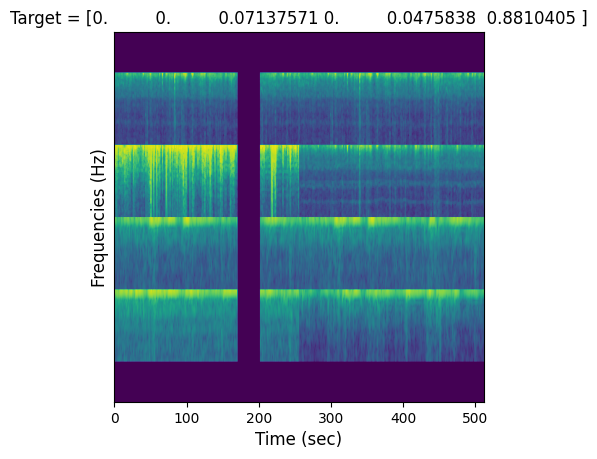

In [13]:
if not submission and DATA_TYPE!='raw':
    gen = DataGenerator(train, augment=True, specs=spectrograms, eeg_specs=all_eegs, data_type=DATA_TYPE)
    for x,y in gen:
        break
    plt.imshow(x[0,:,:,0])
    plt.title(f'Target = {y[0]}',size=12)
    plt.yticks([])
    plt.ylabel('Frequencies (Hz)',size=12)
    plt.xlabel('Time (sec)',size=12)
    plt.show()


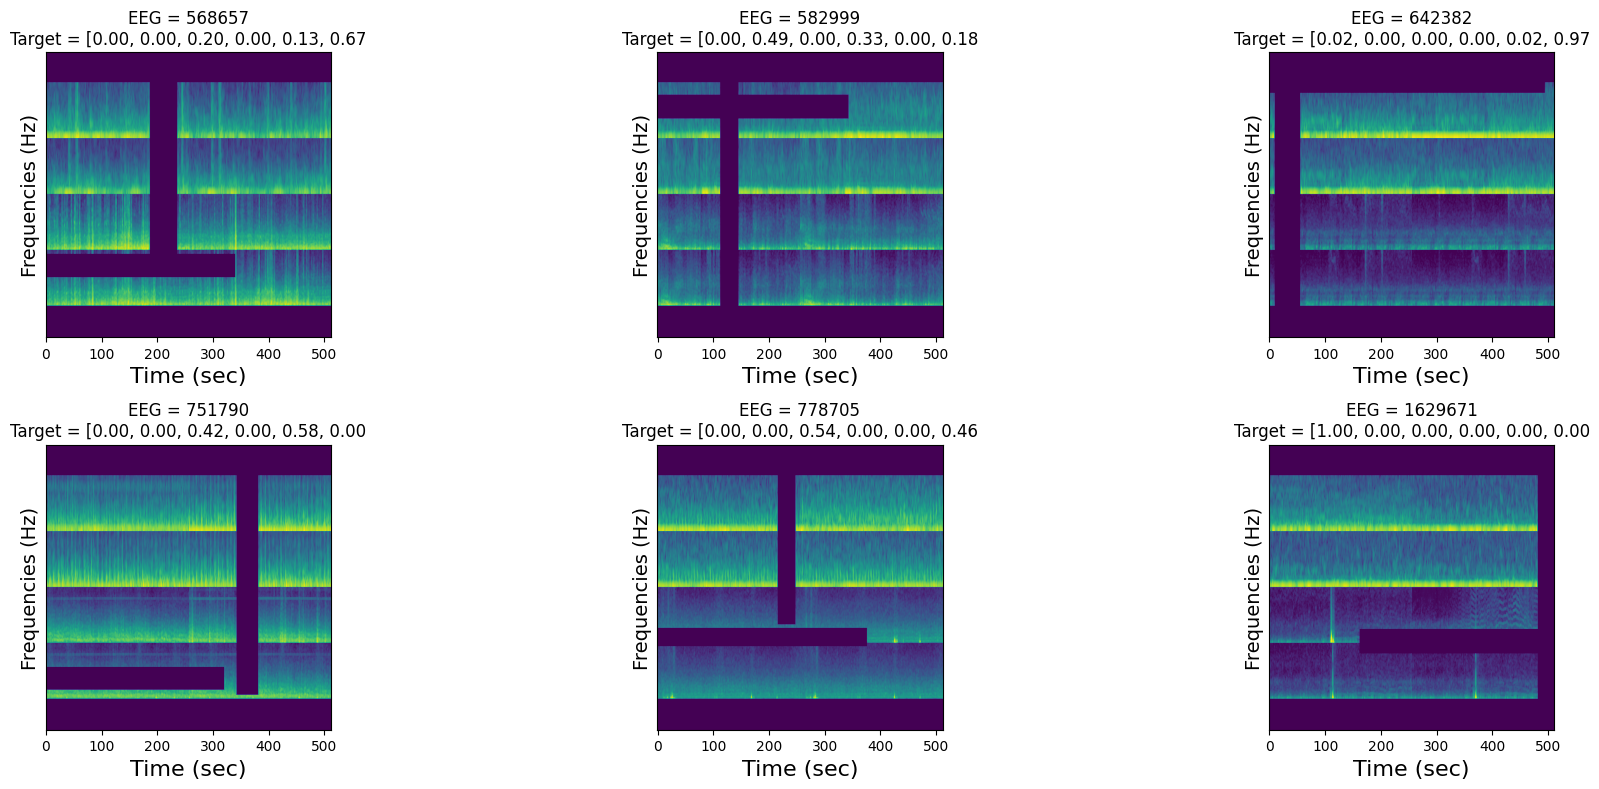

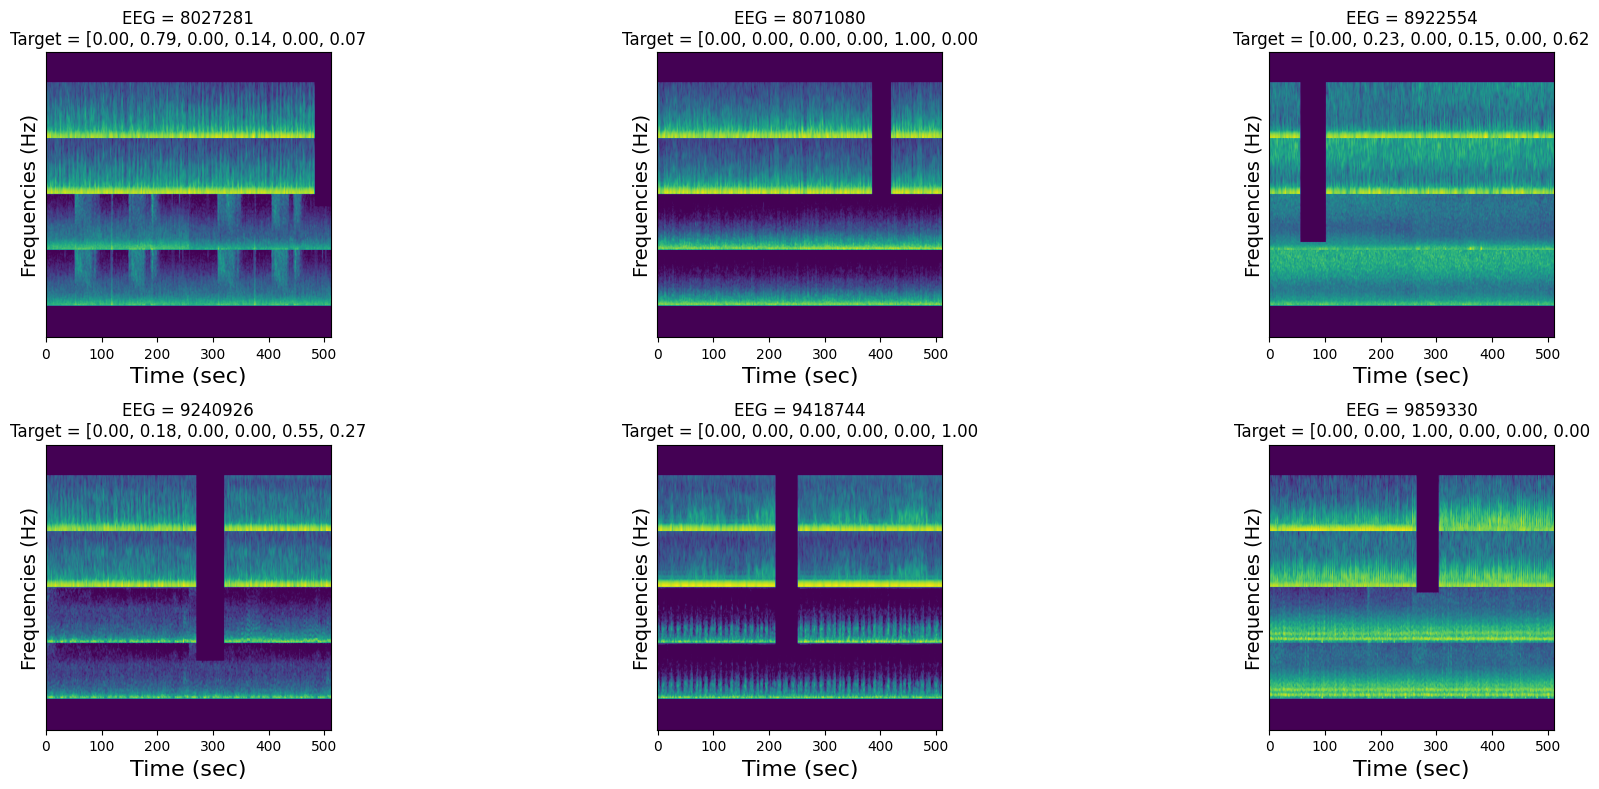

In [15]:
gen = DataGenerator(train, batch_size=32, shuffle=False, mode='train', augment=True,specs=spectrograms, eeg_specs=all_eegs, data_type=DATA_TYPE)
ROWS=2; COLS=3; BATCHES=2

for i,(x,y) in enumerate(gen):
    plt.figure(figsize=(20,8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS,COLS,j*COLS+k+1)
            t = y[j*COLS+k]
            img = x[j*COLS+k,:,:,0][::-1,]
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.tight_layout()
            plt.imshow(img)
            tars = f'[{t[0]:0.2f}'
            for s in t[1:]: tars += f', {s:0.2f}'
            eeg = train.eeg_id.values[i*32+j*COLS+k]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    if i==BATCHES-1: break
        

# 訓練

## 学習率スケジューラーの調整  
LR：1回目の学習に使用  
LR2 : 2回目の学習に使用

In [10]:
if not submission:

    def lrfn(epoch):
        return [1e-3,1e-3,1e-3,1e-4,1e-4,1e-5][epoch]

    LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    
    def lrfn2(epoch):
        return [1e-5,1e-5,1e-6][epoch]

    LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn2, verbose = True)

## MODEL構築

In [11]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate

def build_model():  
    inp = tf.keras.layers.Input((512,512,3))
    print(inp.shape)
    base_model = load_model(f'{LOAD_BACKBONE_FROM}')
    x = base_model(inp)
    # 画像の特徴マップ（3次元）を平均プーリングによって2次元に圧縮
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # softmax()によって最終的な出力を各脳波種の生起確率の分布に変換
    output = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    model = tf.keras.Model(inputs=inp, outputs=output)
    # 最適化手法をAdamに設定
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    # 損失関数をKL_Divに設定
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)  
    return model

# 検証データのkl_divスコアの算出
def score(y_true, y_pred):
    kl = tf.keras.metrics.KLDivergence()
    return kl(y_true, y_pred)

# 損失スコアの可視化
def plot_hist(hist):
    metrics = ['loss']
    for i,metric in enumerate(metrics):
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,i+1)
        plt.plot(hist[metric])
        plt.plot(hist[f'val_{metric}'])
        plt.title(f'{metric}',size=12)
        plt.ylabel(f'{metric}',size=12)
        plt.xlabel('epoch',size=12)
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()

In [ ]:
# !pip install --no-index --find-links=/kAaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

In [ ]:
# import efficientnet.tfkeras as efn

# def build_model():
    
#     inp = tf.keras.Input(shape=(512,512,3))
#     base_model = efn.EfficientNetB2(include_top=False, weights=None, input_shape=None)
#     base_model.load_weights('/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')
    
#     # RESHAPE INPUT 128x256x8 => 512x512x3 MONOTONE IMAGE(=>)
#     # KAGGLE SPECTROGRAMS
# #     x1 = [inp[:,:,:,i:i+1] for i in range(4)]
# #     x1 = tf.keras.layers.Concatenate(axis=1)(x1)
# #     # EEG SPECTROGRAMS
# #     x2 = [inp[:,:,:,i+4:i+5] for i in range(4)]
# #     x2 = tf.keras.layers.Concatenate(axis=1)(x2)
# #     # MAKE 512X512X3
# #     if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
# #         x = tf.keras.layers.Concatenate(axis=2)([x1,x2])
# #     elif USE_EEG_SPECTROGRAMS: x = x2
# #     else: x = x1
# #     x = tf.keras.layers.Concatenate(axis=3)([x,x,x])
#     x = inp
#     print(x.shape)
    
#     # OUTPUT
#     x = base_model(x)
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
        
#     # COMPILE MODEL
#     model = tf.keras.Model(inputs=inp, outputs=x)
#     opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
#     loss = tf.keras.losses.KLDivergence()

#     model.compile(loss=loss, optimizer = opt) 
        
#     return model

## TRANSFER LEARNING

In [ ]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

if not submission:
    all_oof = []
    all_true = []
    losses = []
    val_losses = []
    total_hist = {}

    gkf = GroupKFold(n_splits=5)
    for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
        
        print('#'*25)
        print(f'### Fold {i+1}')
        
        data, val = train.iloc[train_index],train.iloc[valid_index]
        train_gen = DataGenerator(data, augment=True, specs=spectrograms, eeg_specs=all_eegs,
                                  raw_eegs=all_raw_eegs,batch_size=32,shuffle=True)
        
        valid_gen = DataGenerator(val, mode='valid', specs=spectrograms, eeg_specs=all_eegs,
                                  raw_eegs=all_raw_eegs,batch_size=64)
        data, val = data[data['kl']<5.5],val[val['kl']<5.5]
        train_gen2 = DataGenerator(data, augment=False, specs=spectrograms, eeg_specs=all_eegs,
                                   raw_eegs=all_raw_eegs,batch_size=32, shuffle=True)
        in_shape = (2000,8) if DATA_TYPE=='raw' else (512,512,3)
        
        EPOCHS = 5 if DATA_TYPE=='raw' else 4
        BATCH_SIZE_PER_REPLICA = 8 if DATA_TYPE=='raw' else 32
        BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

#         train_dataset = tf.data.Dataset.from_generator(generator=train_gen, 
#                                                    output_signature=(tf.TensorSpec(shape=(32,512,512,3), dtype=tf.float32),
#                                                                      tf.TensorSpec(shape=(32,6), dtype=tf.float32)))
#         val_dataset = tf.data.Dataset.from_generator(generator=valid_gen, 
#                                                    output_signature=(tf.TensorSpec(shape=(64,512512,3), dtype=tf.float32),
#                                                                      tf.TensorSpec(shape=(64,6), dtype=tf.float32)))
#         train_dataset2 = tf.data.Dataset.from_generator(generator=train_gen2, 
#                                                    output_signature=(tf.TensorSpec(shape=in_shape, dtype=tf.float32),
#                                                                      tf.TensorSpec(shape=(6,), dtype=tf.float32)))
            
        print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
        print('#'*25)
        
        K.clear_session()
        with strategy.scope():
            if DATA_TYPE=='raw':
                model = build_wave_model()
            else:
                model = build_model()
        
        hist = model.fit(train_gen, validation_data = valid_gen, 
                         epochs=EPOCHS, callbacks=[LR], verbose=1)
        print(f'### seconds stage train size {len(data)}, valid size {len(val)}')
        print('#'*25)
        hist2 = model.fit(train_gen2, validation_data = valid_gen, 
                         epochs=3, callbacks=[LR2])
        losses.append(hist.history['loss']+hist2.history['loss'])
        val_losses.append(hist.history['val_loss']+hist2.history['val_loss'])
        with strategy.scope():
            model.save_weights(f'model_{DATA_TYPE}_{VER}_{i}.weights.h5')
        oof = model.predict(valid_gen, verbose=1)
        all_oof.append(oof)
        all_true.append(train.iloc[valid_index][TARGETS].values)    
        del model, oof
        gc.collect()
        
#     total_hist['loss'] = np.mean(losses,axis=0)
#     total_hist['val_loss'] = np.mean(val_losses,axis=0)
#     all_oof = np.concatenate(all_oof)
#     all_true = np.concatenate(all_true)
#     plot_hist(total_hist)
#     print('#'*25)
#     print(f'CV KL SCORE: {score(all_true,all_oof)}')

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
(None, 512, 512, 3)

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


# 検証データのkl_div scoreを確認

In [ ]:
if not submission:
    total_hist['loss'] = np.mean(losses,axis=0)
    total_hist['val_loss'] = np.mean(val_losses,axis=0)
    all_oof = np.concatenate(all_oof)
    all_true = np.concatenate(all_true)
    plot_hist(total_hist)
    print('#'*25)
    print(f'CV KL SCORE: {score(all_true,all_oof)}')

# Infer Test and Create Submission CSV
Infer the test data and create a `submission.csv` file.

In [ ]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

import librosa

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((100,300,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
            # FILL NANS
            x1 = eeg[COLS[kk]].values
            x2 = eeg[COLS[kk+1]].values
            m = np.nanmean(x1)
            if np.isnan(x1).mean()<1: x1 = np.nan_to_num(x1,nan=m)
            else: x1[:] = 0
            m = np.nanmean(x2)
            if np.isnan(x2).mean()<1: x2 = np.nan_to_num(x2,nan=m)
            else: x2[:] = 0
                
            # COMPUTE PAIR DIFFERENCES
            x = x1 - x2

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//300, 
                  n_fft=1024, n_mels=100, fmin=0, fmax=20, win_length=128)
            
            # LOG TRANSFORM
            width = (mel_spec.shape[1]//30)*30
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.show()
        
    return img

In [ ]:
if submission:
    test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
    print('Test shape',test.shape)
    test.head()

In [ ]:
# READ ALL SPECTROGRAMS
if submission:
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
    files2 = os.listdir(PATH2)
    print(f'There are {len(files2)} test spectrogram parquets')
    
    spectrograms2 = {}
    for i,f in enumerate(files2):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH2}{f}')
        name = int(f.split('.')[0])
        spectrograms2[name] = tmp.iloc[:,1:].values
    
    # RENAME FOR DATA GENERATOR
    test = test.rename({'spectrogram_id':'spec_id'},axis=1)

In [ ]:
# READ ALL EEG SPECTROGRAMS
if submission:
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
    DISPLAY = 0
    EEG_IDS2 = test.eeg_id.unique()
    all_eegs2 = {}

    print('Converting Test EEG to Spectrograms...'); print()
    for i,eeg_id in enumerate(EEG_IDS2):
        
        # CREATE SPECTROGRAM FROM EEG PARQUET
        img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
        all_eegs2[eeg_id] = img

In [ ]:
# READ ALL RAW EEG SIGNALS
if submission :
    all_raw_eegs2 = {}
    EEG_IDS2 = test.eeg_id.unique()
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'

    print('Processing Test EEG parquets...'); print()
    for i,eeg_id in enumerate(EEG_IDS2):
        
        # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
        data = eeg_from_parquet(f'{PATH2}{eeg_id}.parquet')
        all_raw_eegs2[eeg_id] = data

In [ ]:
# Submission ON TEST without ensemble
if submission and not ENSEMBLE:
    preds = []
    
    if DATA_TYPE=='raw':
        test_gen = DataGenerator(test, mode='test', raw_eegs=all_raw_eegs2)
        in_shape = (2000,8)
    else:
        test_gen = DataGenerator(test, mode='test', specs = spectrograms2, eeg_specs = all_eegs2)
        in_shape = (512,512,3)
    
    test_dataset = tf.data.Dataset.from_generator(generator=test_gen, 
                                               output_signature=(tf.TensorSpec(shape=in_shape, dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(64).prefetch(tf.data.AUTOTUNE)
    if DATA_TYPE=='raw':
        model = build_wave_model()
    else:
        model = build_model()

    for i in range(5):
        print(f'Fold {i+1}')
        model.load_weights(f'{LOAD_MODELS_FROM}model_{DATA_TYPE}_{VER}_{i}.weights.h5')
        pred = model.predict(test_dataset, verbose=1)
        preds.append(pred)
        
    pred = np.mean(preds,axis=0)
    print('Test preds shape',pred.shape)

In [ ]:
# Submission ON TEST with ensemble
if submission and ENSEMBLE:
    preds = []
    test_gen_kaggle = DataGenerator(test, mode='test', data_type='kaggle', specs = spectrograms2, eeg_specs = all_eegs2)
    test_dataset_kaggle = tf.data.Dataset.from_generator(generator=test_gen_kaggle, 
                                               output_signature=(tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(64).prefetch(tf.data.AUTOTUNE)
    test_gen_both = DataGenerator(test, mode='test', data_type='both', specs = spectrograms2, eeg_specs = all_eegs2)
    test_dataset_both = tf.data.Dataset.from_generator(generator=test_gen_both, 
                                               output_signature=(tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(64).prefetch(tf.data.AUTOTUNE)

    test_gen_eeg = DataGenerator(test, mode='test', data_type='eeg', specs = spectrograms2, eeg_specs = all_eegs2)
    test_dataset_eeg = tf.data.Dataset.from_generator(generator=test_gen_eeg, 
                                               output_signature=(tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(64).prefetch(tf.data.AUTOTUNE)
    test_gen_raw = DataGenerator(test, mode='test', data_type='raw', raw_eegs=all_raw_eegs2)
    test_dataset_raw = tf.data.Dataset.from_generator(generator=test_gen_raw, 
                                               output_signature=(tf.TensorSpec(shape=(2000,8), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(6,), dtype=tf.float32))).batch(64).prefetch(tf.data.AUTOTUNE)
 
    # LB SCORE FOR EACH MODEL
    lbs = 1 - np.array(LBs)
    weights = lbs/lbs.sum()
    model = build_model()
    model_wave = build_wave_model()

    for i in range(5):
        print(f'Fold {i+1}')
        
        model.load_weights(f'{LOAD_MODELS_FROM}model_kaggle_{VERK}_{i}.weights.h5')
        pred_kaggle = model.predict(test_dataset_kaggle, verbose=1)
        
        model.load_weights(f'{LOAD_MODELS_FROM}model_both_{VERB}_{i}.weights.h5')
        pred_both = model.predict(test_dataset_both, verbose=1)
        
        model.load_weights(f'{LOAD_MODELS_FROM}model_eeg_{VERE}_{i}.weights.h5')
        pred_eeg = model.predict(test_dataset_eeg, verbose=1)
        
        model_wave.load_weights(f'{LOAD_MODELS_FROM}model_raw_{VERR}_{i}.weights.h5')
        pred_raw = model_wave.predict(test_dataset_raw, verbose=1)
        
        pred = np.array([pred_both,pred_eeg,pred_kaggle,pred_raw])
        pred = np.average(pred,axis=0,weights=weights)
        preds.append(pred)
        
    pred = np.mean(preds,axis=0)
    print('Test preds shape',pred.shape)

In [ ]:
if submission:
    sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
    sub[TARGETS] = pred
    sub.to_csv('submission.csv',index=False)
    print('Submissionn shape',sub.shape)
    print()
    print(sub.head().to_string())

In [ ]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
if submission:
    print(sub.iloc[:,-6:].sum(axis=1).to_string())